In [179]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
import xgboost as xgb

from scipy.stats import randint as sp_randint
from sklearn.model_selection import RandomizedSearchCV

from sklearn.model_selection import train_test_split
from sklearn import model_selection
from sklearn.utils import resample

from statsmodels.api import add_constant
import statsmodels.discrete.discrete_model as smt

import seaborn as sns

from imblearn.over_sampling import SMOTE

from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

from sklearn import metrics

In [180]:
heart = pd.read_csv('heart_disease.data',index_col=0, names=['age','sex','cp','threstbps','chol','fbs','restecg','thalach','exang','oldpeak'
                                                 ,'slope','ca','thal','num'])

In [181]:
heart.reset_index(inplace=True)

In [182]:
heart.head()

,age,sex,cp,threstbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
0,28,1,2,130,132,0,2,185,0,0.0,?,?,?,0
1,29,1,2,120,243,0,0,160,0,0.0,?,?,?,0
2,29,1,2,140,?,0,0,170,0,0.0,?,?,?,0
3,30,0,1,170,237,0,1,170,0,0.0,?,?,6,0
4,31,0,2,100,219,0,1,150,0,0.0,?,?,?,0


The columns descriptions are:
1. age: age in years
2. sex: sex (1 = male; 0 = female)
3. cp: chest pain type
        -- Value 1: typical angina
        -- Value 2: atypical angina
        -- Value 3: non-anginal pain
        -- Value 4: asymptomatic
4. trestbps: resting blood pressure (in mm Hg on admission to the 
        hospital)
5. chol: serum cholestoral in mg/dl
6. fbs: (fasting blood sugar > 120 mg/dl)  (1 = true; 0 = false)
7. restecg: resting electrocardiographic results
        -- Value 0: normal
        -- Value 1: having ST-T wave abnormality (T wave inversions and/or ST 
                    elevation or depression of > 0.05 mV)
        -- Value 2: showing probable or definite left ventricular hypertrophy
                    by Estes' criteria
8. thalach: maximum heart rate achieved
9. exang: exercise induced angina (1 = yes; 0 = no)
10. oldpeak = ST depression induced by exercise relative to rest
11. slope: the slope of the peak exercise ST segment
        -- Value 1: upsloping
        -- Value 2: flat
        -- Value 3: downsloping
12. ca: number of major vessels (0-3) colored by flourosopy
13. thal: 3 = normal; 6 = fixed defect; 7 = reversable defect
14. num: diagnosis of heart disease (angiographic disease status)
        -- Value 0: < 50% diameter narrowing
        -- Value 1: > 50% diameter narrowing
        (in any major vessel: attributes 59 through 68 are vessels)

In [183]:
heart.describe()

,age,sex,cp,oldpeak,num
count,294.000000,294.000000,294.000000,294.000000,294.000000
mean,47.826531,0.724490,2.982993,0.586054,0.360544
std,7.811812,0.447533,0.965117,0.908648,0.480977
min,28.000000,0.000000,1.000000,0.000000,0.000000
25%,42.000000,0.000000,2.000000,0.000000,0.000000
50%,49.000000,1.000000,3.000000,0.000000,0.000000
75%,54.000000,1.000000,4.000000,1.000000,1.000000
max,66.000000,1.000000,4.000000,5.000000,1.000000


# Treating Missing Values

In [184]:
heart.replace('?',np.nan,inplace=True) #Replacing all the '?' values to none value for missing value treatment

In [185]:
heart.info() #checing the data type of each column

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294 entries, 0 to 293
Data columns (total 14 columns):
age          294 non-null int64
sex          294 non-null int64
cp           294 non-null int64
threstbps    293 non-null object
chol         271 non-null object
fbs          286 non-null object
restecg      293 non-null object
thalach      293 non-null object
exang        293 non-null object
oldpeak      294 non-null float64
slope        104 non-null object
ca           3 non-null object
thal         28 non-null object
num          294 non-null int64
dtypes: float64(1), int64(4), object(9)
memory usage: 32.2+ KB


In [186]:
#Before treating the missing value, we will convert the datatype of respective columns to their actual datatype
#Information can be found out from column description

heart.sex = heart.sex.astype('category')
heart.cp = heart.cp.astype('category')
heart.threstbps = heart.threstbps.astype('float64')
heart.chol = heart.chol.astype('float64')
heart.fbs = heart.fbs.astype('category')
heart.restecg  = heart.restecg.astype('category')
heart.thalach = heart.thalach.astype('float64')
heart.exang= heart.exang.astype('category')
heart.slope = heart.slope.astype('category')
heart.ca = heart.ca.astype('float64')
heart.thal = heart.thal.astype('category')
heart.num = heart.num.astype('int64')

In [187]:
heart.isnull().sum() #Number of Missing values

age            0
sex            0
cp             0
threstbps      1
chol          23
fbs            8
restecg        1
thalach        1
exang          1
oldpeak        0
slope        190
ca           291
thal         266
num            0
dtype: int64

In [188]:
heart.shape #Total number of rows

(294, 14)

In [189]:
# As the number of null values in slope, ca and that  columns are too high, we will not use these columns for prediction
# because remaining data is too low to contribute towards full sample
# Even though slope has around 100 values but it is categorical in nature, filling null with the mode will create bias

heart.drop(['slope','ca','thal'], inplace=True,axis=1)

In [190]:
# Missing value in threstbps to be filled with median as variable is continuous

heart.threstbps.fillna(heart.threstbps.median(), inplace=True)

In [191]:
#Missing value in chol to be filled with median as variable is continuous

heart.chol.fillna(heart.chol.median(), inplace=True)

In [192]:
#fbs is a categorical column with 266 zeros and 20 1's so we will fill the null values with 0 as it has a high propbabilit of 
#occurance

heart.fbs.fillna(heart.fbs.mode(),inplace=True)

In [193]:
#Checking the most repeated value in restecg
heart.restecg.value_counts()

0    235
1     52
2      6
Name: restecg, dtype: int64

In [194]:
#Restecg is a categorical column so we will fill the null values with mode

heart.restecg.fillna('0', inplace=True)

In [195]:
#Thalach is a continuos column so we will fill the null values with median

heart.thalach.fillna(heart.thalach.median(),inplace=True)

In [196]:
#Checking the most repetitive value in exang
heart.exang.value_counts()

0    204
1     89
Name: exang, dtype: int64

In [197]:
#Exang is a categorical column so we will fill the null values with mode

heart.exang.fillna('0', inplace=True)

In [198]:
heart.isnull().sum() #Checking for the null values

age          0
sex          0
cp           0
threstbps    0
chol         0
fbs          8
restecg      0
thalach      0
exang        0
oldpeak      0
num          0
dtype: int64

# Exploratory Data Analysis

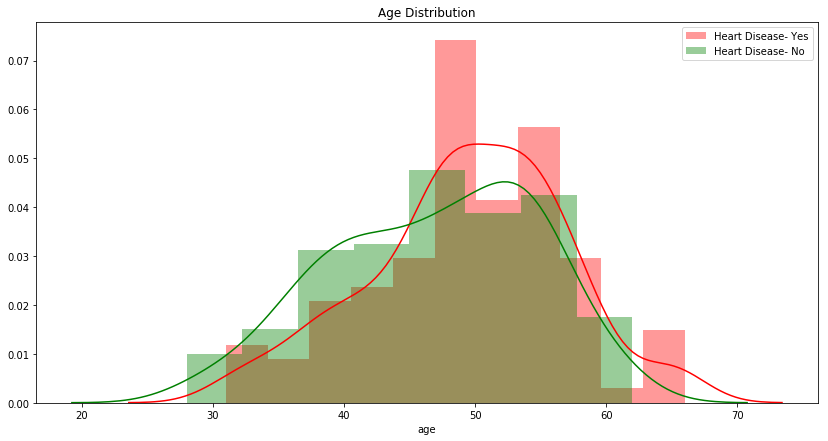

In [199]:
plt.figure(figsize=(14,7))
sns.distplot(heart.age[heart.num == 1], kde=True, color='r',label='Heart Disease- Yes')
sns.distplot(heart.age[heart.num == 0], kde=True,color='g',label='Heart Disease- No')
plt.title('Age Distribution')
plt.legend()
plt.show()

This plot represents the age distribution, here we can infer that for age above 45, the probability of having a heart disease is high

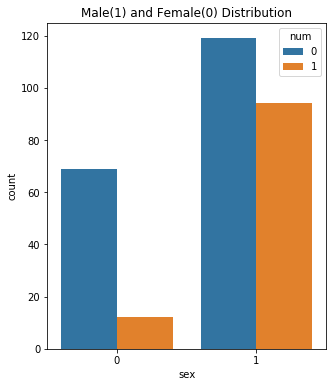

In [200]:
plt.figure(figsize=(5,6))
sns.countplot(x='sex',hue='num',data=heart)
plt.title('Male(1) and Female(0) Distribution')
plt.show()

Male is having high probability of having heart disease than female

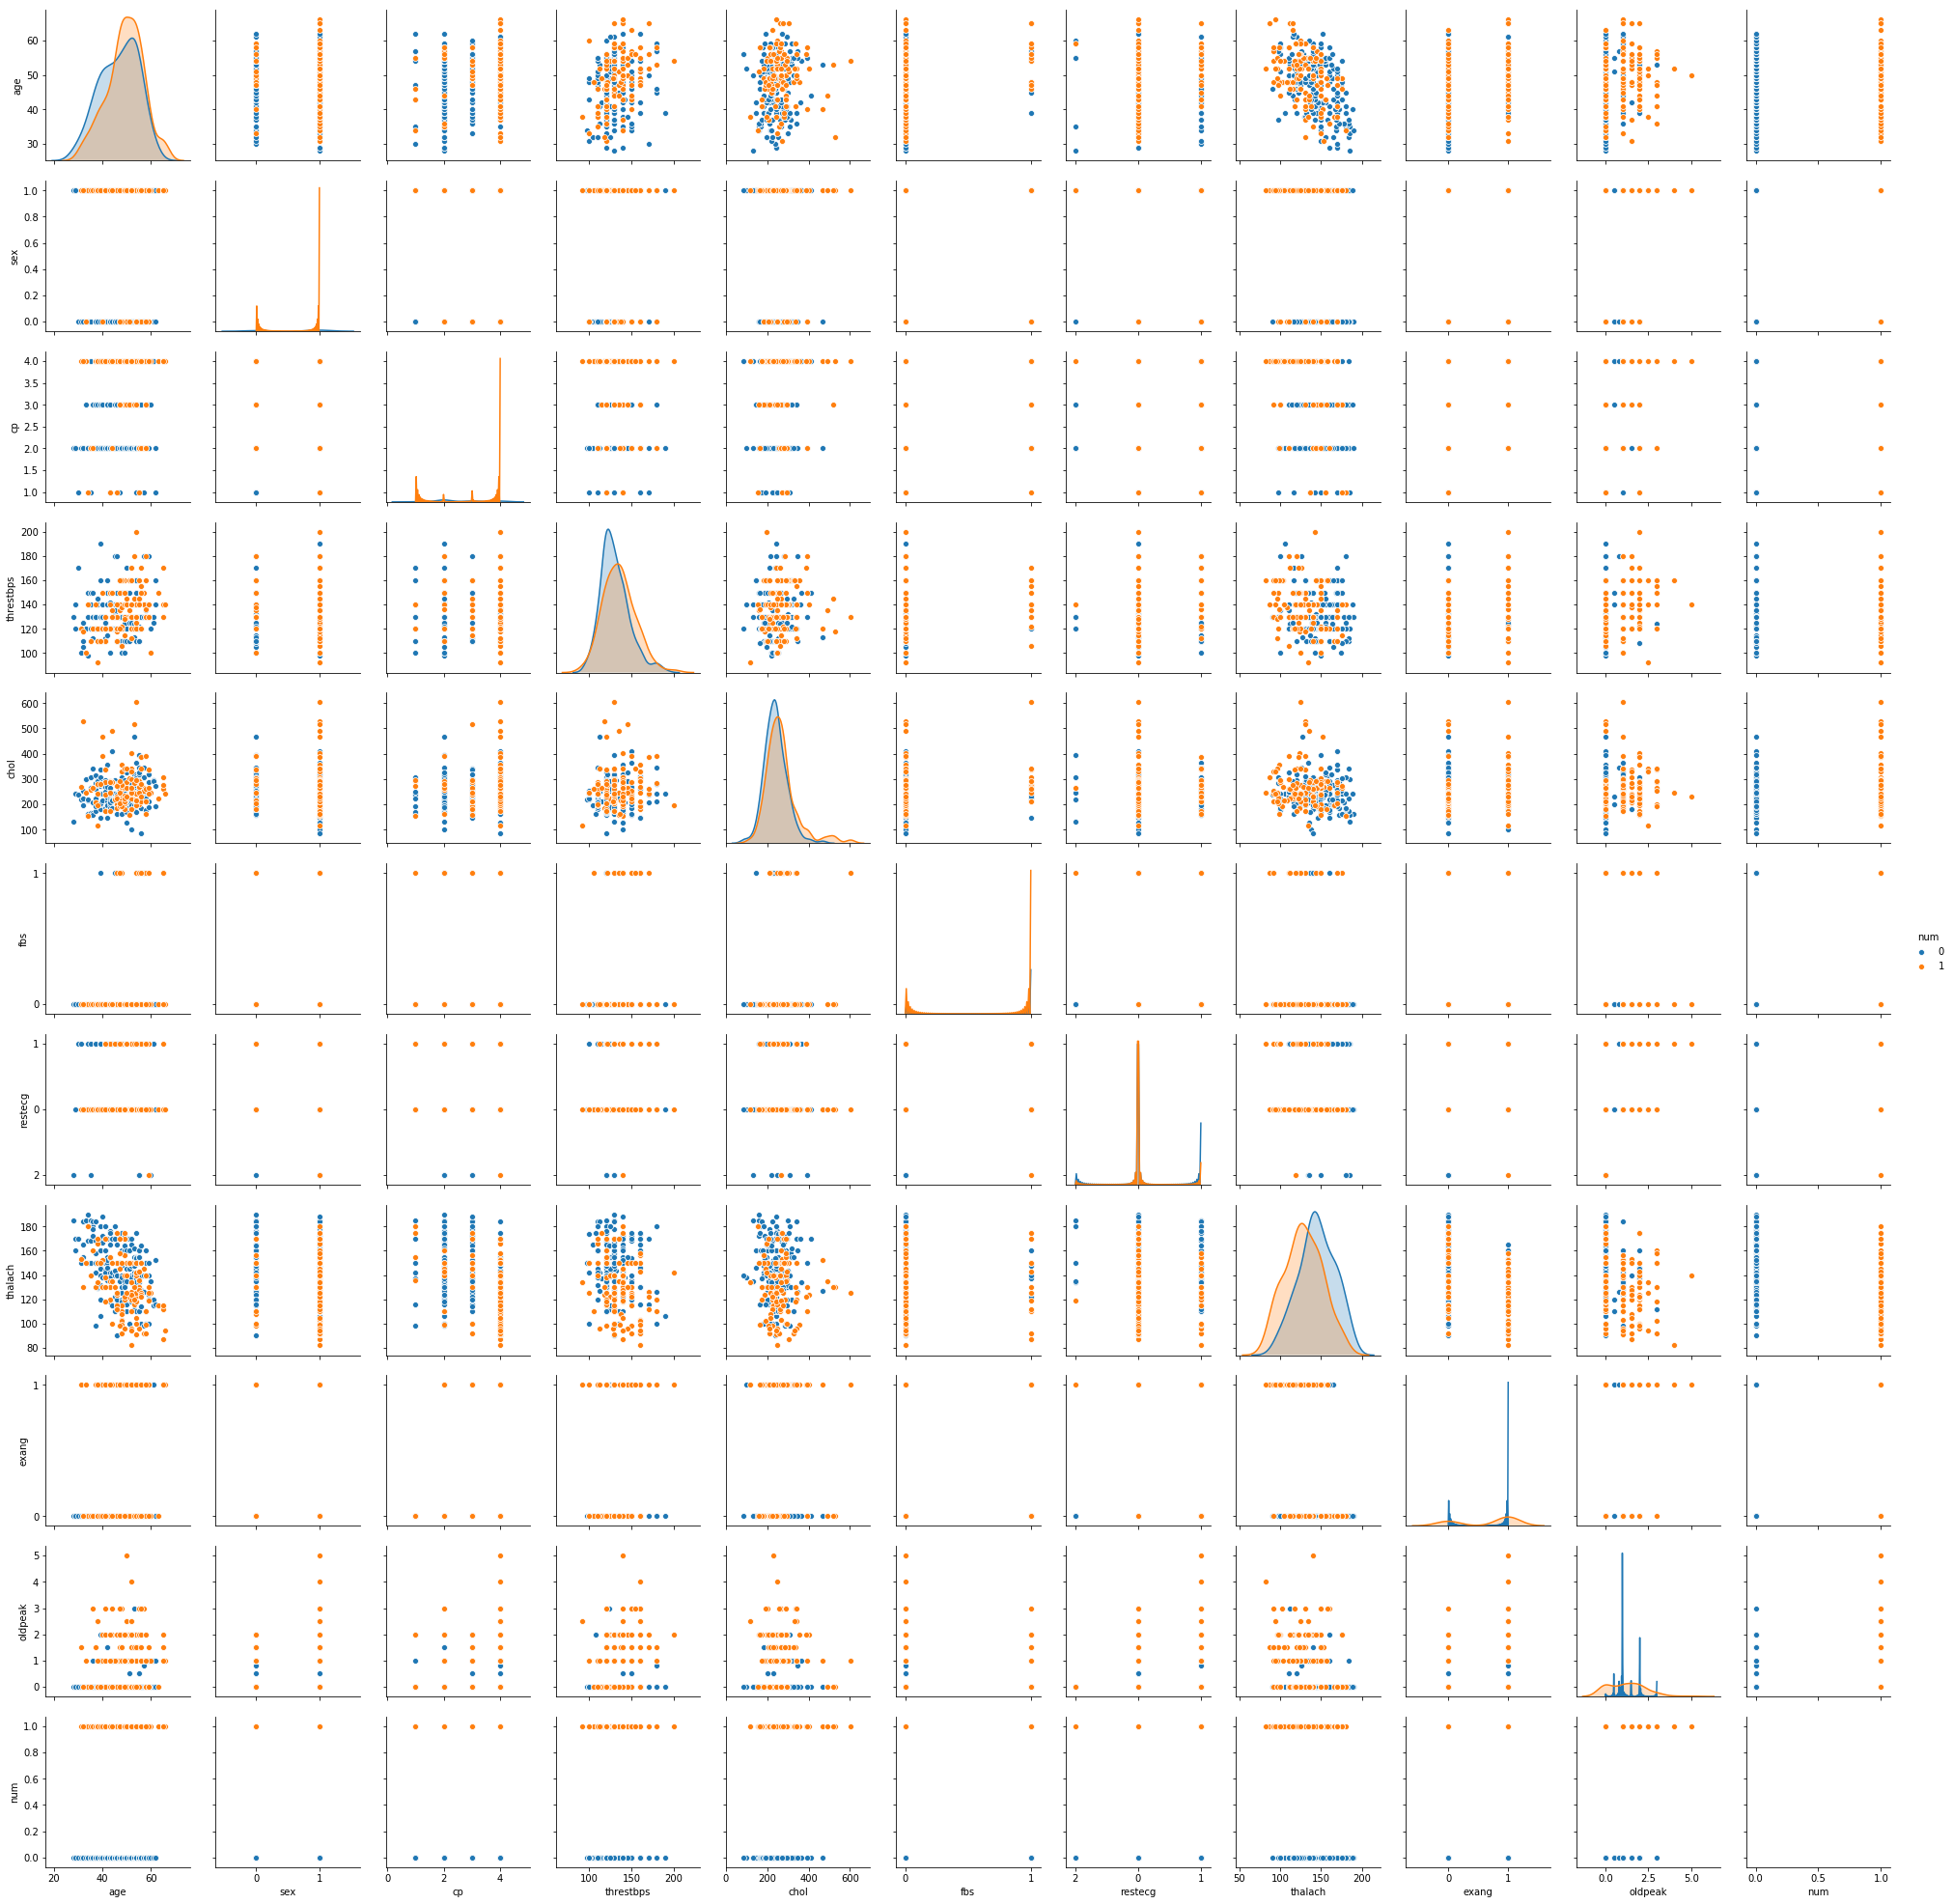

In [201]:
sns.pairplot(heart, diag_kind='kde', hue='num')
plt.show()

Most of the data has categorical column so we can just see the line for their levels and in the diagonal line we can see the distribution for the people with heart disease and not having heart disease. It interprets that the sample population is uniformly distributed for both the variable of heart disease, i.e, 0 and 1.

For target categorical variable num,  we cannot interpret much as the value is either having 0 or 1

There is a negative correlation between thalach and age, apart from this plots of continuous variable shows no linear relation

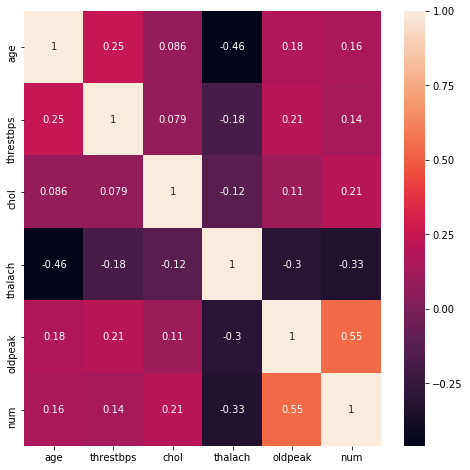

In [202]:
plt.figure(figsize=(8,8))
sns.heatmap(heart.corr(),annot=True)
plt.show()

Here we can see all the non-categorical columns and target column and their co-relation with each other. Thalach is having a high co-relation with our target variable, otherwise thalech has high correlation with age as we observed in pairplot

## Create Dummies

In [203]:
#We will create dummies for the categorical column in the dataset
heart = pd.get_dummies(heart) 

In [204]:
heart.head()

,age,threstbps,chol,thalach,oldpeak,num,sex_0,sex_1,cp_1,cp_2,cp_3,cp_4,fbs_0,fbs_1,restecg_0,restecg_1,restecg_2,exang_0,exang_1
0,28,130.0,132.0,185.0,0.0,0,0,1,0,1,0,0,1,0,0,0,1,1,0
1,29,120.0,243.0,160.0,0.0,0,0,1,0,1,0,0,1,0,1,0,0,1,0
2,29,140.0,243.0,170.0,0.0,0,0,1,0,1,0,0,1,0,1,0,0,1,0
3,30,170.0,237.0,170.0,0.0,0,1,0,1,0,0,0,1,0,0,1,0,1,0
4,31,100.0,219.0,150.0,0.0,0,1,0,0,1,0,0,1,0,0,1,0,1,0


In [205]:
heart.shape 

(294, 19)

## Target Variable Analysis

In [206]:
heart.num.value_counts()

0    188
1    106
Name: num, dtype: int64

As you can see that the number of people not having heart disease is more than people having the heart disease, so we will make use of overpopulation technique so that our model will not be biased towards 0 

In [207]:
#Using SMOTE to do the over-sampling

x= heart.drop('num', axis=1)
y= heart.num
sm = SMOTE(k_neighbors=5,random_state=1)
x,y =sm.fit_sample(x,y)
x= pd.DataFrame(x, columns=['age', 'threstbps', 'chol', 'thalach', 'oldpeak', 'sex_0',
       'sex_1', 'cp_1', 'cp_2', 'cp_3', 'cp_4', 'fbs_0', 'fbs_1', 'restecg_0',
       'restecg_1', 'restecg_2', 'exang_0', 'exang_1'])
y=pd.DataFrame(y, columns=['num'])

heartos = pd.concat([x,y],axis=1)
heartos.shape

(376, 19)

In [208]:
heartos.num.value_counts() #Now the sample is balanced

1    188
0    188
Name: num, dtype: int64

# Modelling

## Split the data into test and train

In [209]:
# Split the data in test and train

x= heartos.drop('num', axis=1)
y= heartos.num

#If standard value is required
sc = StandardScaler()
x_std = sc.fit_transform(x)

x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.3,random_state=2)

#If standard value id required
x_train_std = sc.fit_transform(x_train)
x_test_std = sc.fit_transform(x_test)

For classification model, we will make use of following: (ensemble we will use later)

1. Logistic Regression
2. KNN Classifier
3. Decision Tree
4. Gaussian Naive Bayes

### 1. Logistic Regression

In [210]:
logreg = LogisticRegression()
logreg.fit(x_train,y_train)
print('The accuracy score for Logistic Regression model is %1.2f per cent' %((logreg.score(x_test,y_test))*100))

The accuracy score for Logistic Regression model is 87.61 per cent


### 2. KNN Classifier

In [211]:
#For knn model we will first find out the best number of neighbors to be selected using grid search algorithm

knncl = KNeighborsClassifier()
param= {'n_neighbors': range(1,30)}
knngrid = GridSearchCV(knncl, param_grid= param, cv=5)
knngrid.fit(x_std,y) #for distance based model we use standardize values
knngrid.best_params_

{'n_neighbors': 27}

In [212]:
knncl = KNeighborsClassifier(n_neighbors=27)
knncl.fit(x_train_std,y_train)
print('The accuracy score for KNN Classifier model is %1.2f per cent' %((knncl.score(x_test_std,y_test))*100))

The accuracy score for KNN Classifier model is 84.96 per cent


### 3. Decision Tree

In [213]:
#Foe decision tree we will again do the grid search for max depth, otherwise model will become over-fit

dtcl = DecisionTreeClassifier()
params= {'max_depth': np.arange(1,30)}
dtgrid= GridSearchCV(dtcl,params,cv=5)
dtgrid.fit(x,y)
dtgrid.best_params_

{'max_depth': 1}

In [214]:
dtcl = DecisionTreeClassifier(max_depth=1)
dtcl.fit(x_train, y_train)
print('The accuracy score for Decision Tree model is %1.2f per cent' %((dtcl.score(x_test,y_test)*100)))

The accuracy score for Decision Tree model is 82.30 per cent


### 4. Gaussian Naive Bayes

In [215]:
gnbcl = GaussianNB()
gnbcl.fit(x_train, y_train)
print('The accuracy score for Gaussian Naive Bayes model is %1.2f per cent' %((gnbcl.score(x_test,y_test)*100)))

The accuracy score for Gaussian Naive Bayes model is 79.65 per cent


# Ensemble Techniques

In ensemble techiques, we will make use of following classification models:
1. Random Forest Classifier
2. Bagging Classifier
3. Ada Boost Classifier
4. Gradient Boost Classifier
5. XG Boosting Classifier

### 1. Random Forest Classifier

In [216]:
rfcl = RandomForestClassifier()
param = {'n_estimators': sp_randint(1, 80)}
randomCV = RandomizedSearchCV(rfcl, param_distributions=param, n_iter=80)
randomCV.fit(x,y)
randomCV.best_params_

{'n_estimators': 28}

In [217]:
rfcl = RandomForestClassifier(n_estimators=45)
rfcl.fit(x_train, y_train)
print('The accuracy score for Random Forest model is %1.2f per cent' %((rfcl.score(x_test,y_test)*100)))

The accuracy score for Random Forest model is 84.96 per cent


### 2. Bagging Classifier

In [218]:
bgcl = BaggingClassifier()
param = {'n_estimators': sp_randint(1, 80)}
randomCV = RandomizedSearchCV(bgcl, param_distributions=param, n_iter=80)
randomCV.fit(x,y)
randomCV.best_params_

{'n_estimators': 74}

In [219]:
bgcl = BaggingClassifier(n_estimators=31)
bgcl.fit(x_train, y_train)
print('The accuracy score for Bagging Classifier model is %1.2f per cent' %((bgcl.score(x_test,y_test)*100)))

The accuracy score for Bagging Classifier model is 80.53 per cent


### 3. Ada Boost Classifier

In [220]:
abcl = AdaBoostClassifier()
param = {'n_estimators': sp_randint(1, 80)}
randomCV = RandomizedSearchCV(abcl, param_distributions=param, n_iter=80)
randomCV.fit(x,y)
randomCV.best_params_

{'n_estimators': 1}

In [221]:
abcl = AdaBoostClassifier(n_estimators=1)
abcl.fit(x_train, y_train)
print('The accuracy score for Adaptive Boosting model is %1.2f per cent' %((abcl.score(x_test,y_test)*100)))

The accuracy score for Adaptive Boosting model is 82.30 per cent


### 4. Gradient Boost Classifier

In [222]:
gbcl = GradientBoostingClassifier()
param = {'n_estimators': sp_randint(1, 80)}
randomCV = RandomizedSearchCV(gbcl, param_distributions=param, n_iter=80)
randomCV.fit(x,y)
randomCV.best_params_

{'n_estimators': 62}

In [223]:
gbcl = GradientBoostingClassifier(n_estimators = 58)
gbcl.fit(x_train,y_train)
print('The accuracy score for Gradient Boosting model is %1.2f per cent' %((gbcl.score(x_test,y_test)*100)))

The accuracy score for Gradient Boosting model is 79.65 per cent


### 5. XG Boosting Classifier

In [224]:
xgcl = xgb.XGBClassifier()
param = {'n_estimators': sp_randint(1, 80)}
randomCV = RandomizedSearchCV(xgcl, param_distributions=param, n_iter=80)
randomCV.fit(x,y)
randomCV.best_params_

{'n_estimators': 8}

In [225]:
xgcl = xgb.XGBClassifier(n_estimators=8)
xgcl.fit(x_train, y_train)
print('The accuracy score for XG Boost model is %1.2f per cent' %((xgcl.score(x_test,y_test)*100)))

The accuracy score for XG Boost model is 84.96 per cent


# Model Comparision

## K-Fold Analysis

By doing k-fold analysis, we will check which of our models are performing well and should be choosed for hybrid model

In [226]:
#We will perform this validation to check which model is workling consistently better among these nine

models=[]
models.append(('Logistic Regression', logreg))
models.append(('Naive Bayes     ', gnbcl))
models.append(('KNeighbour      ',knncl))
models.append(('Decision Tree     ',dtcl))
models.append(('Random Forest   ', rfcl))
models.append(('Bagging Classifier', bgcl))
models.append(('Ada Boosting     ',abcl))
models.append(('Gradient Boosting',gbcl))
models.append(('XG Boost Classifier',xgcl))

In [227]:
results= []
names= []

for name,model in models:
    kfold= model_selection.KFold(n_splits = 10, random_state=2, shuffle=True)
    cv_results = model_selection.cross_val_score(model, x, y, cv=kfold, scoring='accuracy')
    results.append(cv_results)
    names.append(name)
    msg = "%s:\t %f (%f)" %(name,cv_results.mean(),cv_results.std())
    print(msg)

Logistic Regression:	 0.832006 (0.063864)
Naive Bayes     :	 0.805619 (0.054263)
KNeighbour      :	 0.648720 (0.073039)
Decision Tree     :	 0.787127 (0.049032)
Random Forest   :	 0.858890 (0.038115)
Bagging Classifier:	 0.842888 (0.055532)
Ada Boosting     :	 0.787127 (0.049032)
Gradient Boosting:	 0.856117 (0.054343)
XG Boost Classifier:	 0.834922 (0.043035)


Random foresr is the top perfomer in the group followed by gradient boosting, bagging classifier, XG Boost and Logistic. We will use top perfomers to create hybrid model

# Hybrid Model

In order to create a hybrid model, we will choose the models which are giving better and consistent performance. In the above k-fold analysis, we can see that the best performers among our nine classification models are:
1. Random Forest
2. Gradient Boosting
3. Bagging Classifier
4. XG Boost Classifier
5. Logistic Regression

So, we will make use of these model to create hybrid model

In [228]:
rfcl = RandomForestClassifier(n_estimators=45)
gbcl = GradientBoostingClassifier(n_estimators = 63)
bgcl = BaggingClassifier(n_estimators=31)
xgcl = xgb.XGBClassifier(n_estimators=8)
logreg = LogisticRegression()

hycl = VotingClassifier(estimators = [('RandomForest', rfcl),('Gradient Boosting', gbcl),('Bagging Classifier', bgcl),
                                      ('XG Boost', xgcl), ('Logistic Regression', logreg)])

In [229]:
#Train and Test analysis

hycl.fit(x_train,y_train)
print('The accuracy of hybrid model is : %1.4f'hycl.score(x_test,y_test)

SyntaxError: invalid syntax (<ipython-input-229-b707e62d2610>, line 4)

In [ ]:
#Confusion Matrix for Hybrid Model

ypred = hycl.predict(x_test)

print(metrics.confusion_matrix(y_test,ypred))

In [ ]:
#Classifcation Report for Hybrid Model

print(metrics.classification_report(y_test,ypred))

In [ ]:
#Kfold Analysis

kfold= model_selection.KFold(n_splits = 10, random_state=2, shuffle=True)
cv_results = model_selection.cross_val_score(model, x, y, cv=kfold, scoring='accuracy')
print("Hybrid Model k-fold Accuracy Score :\t %f (%f)" %(cv_results.mean(),cv_results.std()))
 

### Confidence Interval for Hybrid Model

In [ ]:
# We will do bootstrap sampling and get 50 different results to get the confidence interval

temp = pd.concat([x,y],axis=1) #So that the taget variable will be at the last column
values= temp.values

iterations = 50
n_size = int(len(values)*0.7)

hystats = []

for i in range(iterations):
    train = resample(values,n_samples=n_size)
    test = np.array([x for x in values if x.tolist() not in train.tolist()])
    
    hycl = VotingClassifier(estimators = [('RandomForest', rfcl),('Gradient Boosting', gbcl),('Bagging Classifier', bgcl),
                                      ('XG Boost', xgcl), ('Logistic Regression', logreg)])
    hycl.fit(train[:,:-1] ,train[:,-1])
    hyscore = hycl.score(test[:,:-1],test[:,-1])
    hystats.append(hyscore)

In [ ]:
sns.distplot(hystats)
plt.title('Random Forest Algorithm')
plt.show()

confidence = 95
lower = (100-confidence)/2
upper = confidence + lower

print('The ',confidence, '% confidence interval is: ',round(np.percentile(hystats,lower),4)*100,
      '% to ',round(np.percentile(hystats,upper),4)*100,'%')

We have prepared the Hybrid Classification model, this model will have the 95% confidence interval of 78.99% to 88.16%

The End